# Iteration 0: Cell to cell type assignment. Cell label = 13043¶

In [ ]:
# Uncomment the line below to show all rows in a pandas dataframe
# import pandas as pd
# pd.set_option('display.max_rows', None)

### This is a notebook demonstrating what happens under the hood in the cell to cell type step in pciSeq

The focus here is on a particular cell (with label 13043) that has 24 gene counts but inside the first iteration the most likely class is the Zero class. The interesting aspect here is that the negative binomial doesnt yiled the Zero class as the most likely. It is the prior that shifts the results because the prior puts more weight to the zero class (50%) than to any other. However in the next iteration Zero class is replaced by TEGLU4 as the most likely class

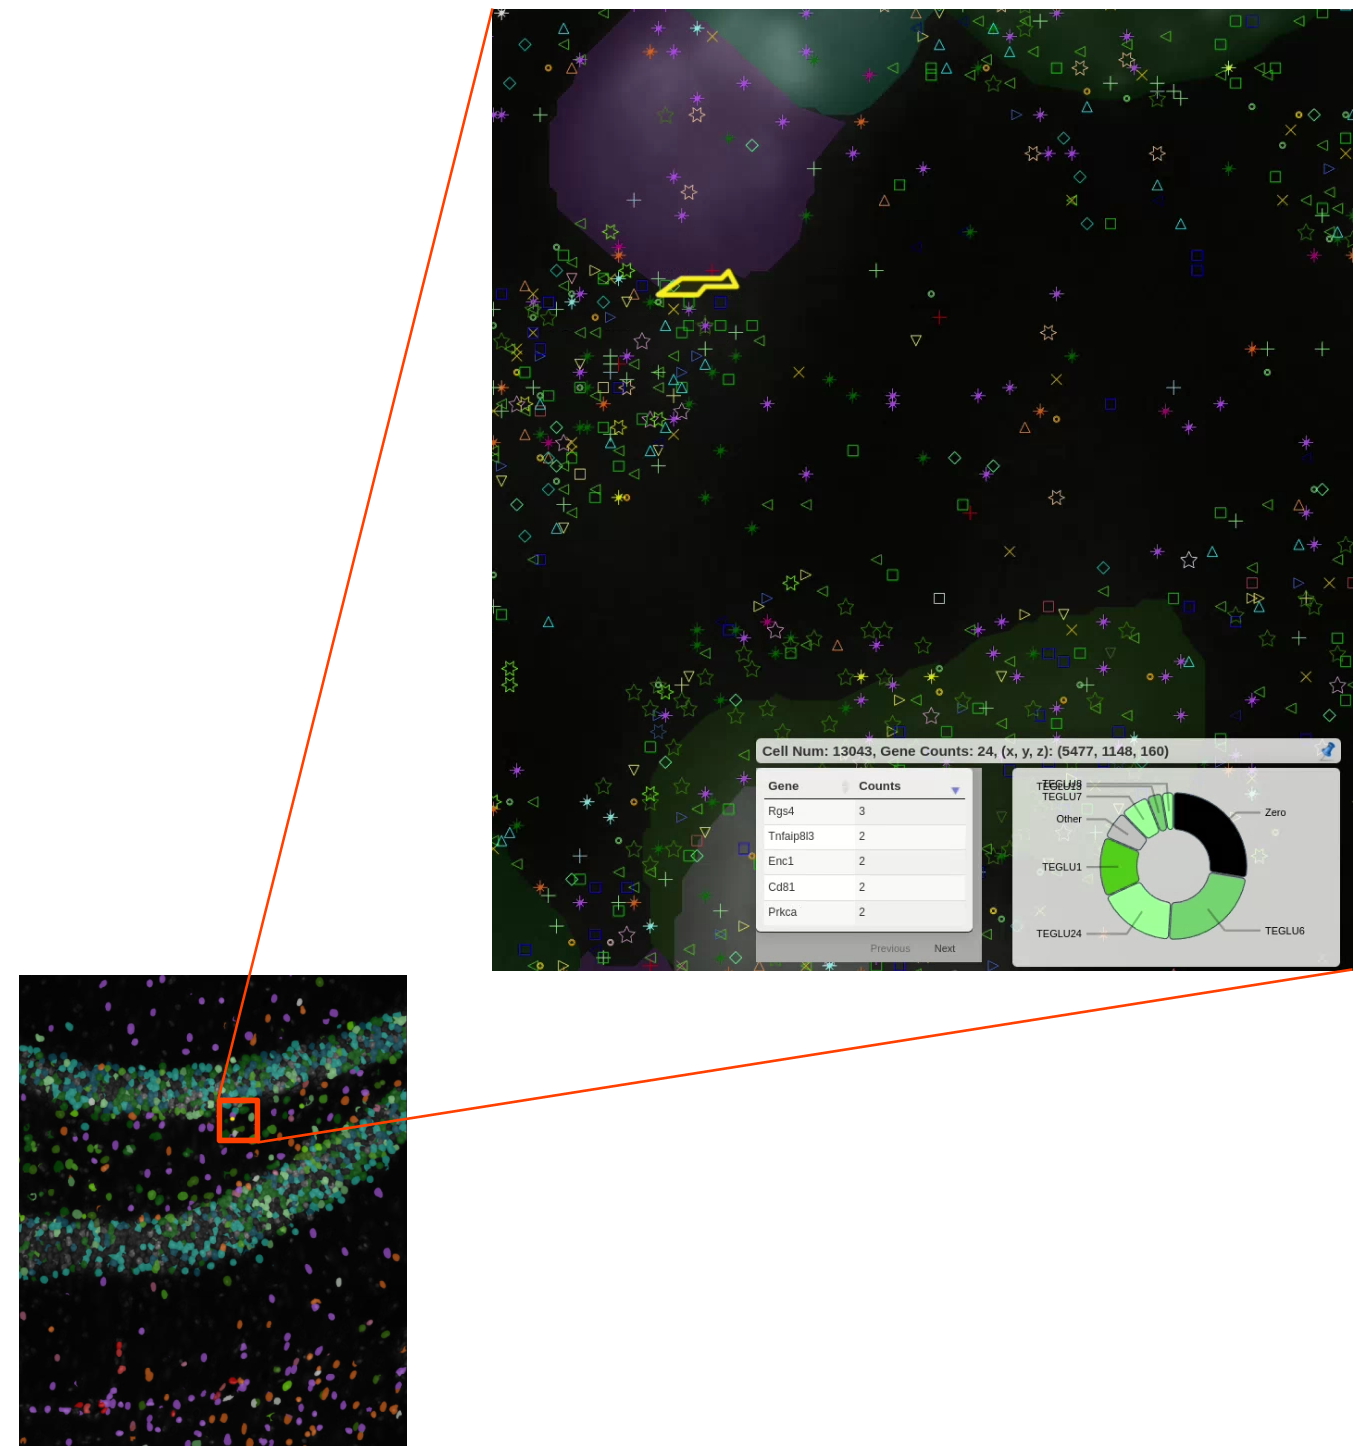

In [1]:
!pip install gdown

In [2]:
import pandas as pd
import numpy as np
import scipy
from scipy.special import softmax
import gdown

In [3]:
!pip install git+https://github.com/acycliq/pciSeq.git@dev_3d
import pciSeq

  Cloning https://github.com/acycliq/pciSeq.git (to revision dev_3d) to /tmp/pip-req-build-wa1w7ja8
  Running command git clone --filter=blob:none --quiet https://github.com/acycliq/pciSeq.git /tmp/pip-req-build-wa1w7ja8
  Running command git checkout -b dev_3d --track origin/dev_3d
  Switched to a new branch 'dev_3d'
  Branch 'dev_3d' set up to track remote branch 'dev_3d' from 'origin'.
  Resolved https://github.com/acycliq/pciSeq.git to commit 31fd7688f1f848d9e59931636ce39479614ea23d
  Preparing metadata (setup.py) ... done


In [4]:
file_id = "1wY1PUvAwk_S9MhKbCyB0HzH9oxNloP0M"
url = f"https://drive.google.com/uc?export=download&id={file_id}"
output = "pciSeq.pickle"

In [5]:
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1wY1PUvAwk_S9MhKbCyB0HzH9oxNloP0M
From (redirected): https://drive.google.com/uc?export=download&id=1wY1PUvAwk_S9MhKbCyB0HzH9oxNloP0M&confirm=t&uuid=f7538c4b-16da-4200-a092-e640b8cb875f
To: /tmp/pciSeq/data/pciSeq.pickle
100%|██████████████████████████████████████| 1.79G/1.79G [03:21<00:00, 8.89MB/s]


'pciSeq.pickle'

In [6]:
obj = pd.read_pickle(output)

In [7]:
my_cell = 13043

In [8]:
# Set the hyperparameters
rSpot = 2.0               # Spread of the negative binomial
SpotReg = 0.1             # Spot regularization: Additive factor applied to the single cell data
inefficiency = 0.2        # multiplicative factor applied to the single cell data

In [9]:
# Another piece of information comes from the single cell data. For simplicity
# we are pulling here only the most probable classes
my_class_definitions = obj.single_cell.mean_expression[
['TEGLU6', 'TEGLU24', 'TEGLU1', 'TEGLU7', 'TEGLU13', 'TEGLU8', 'TEGLU3', 'TEGLU23', 'Zero']
]
my_class_definitions

class_name,TEGLU6,TEGLU24,TEGLU1,TEGLU7,TEGLU13,TEGLU8,TEGLU3,TEGLU23,Zero
gene_name,,,,,,,,,
Abi3bp,0.090301,0.006382,0.300995,0.120739,0.007874,0.035819,0.100585,0.000000,0.0
Acly,0.096990,0.133039,0.154229,0.209856,0.236220,0.199284,0.194221,0.247934,0.0
Adcyap1,0.053512,0.004418,0.009950,0.120739,0.023622,0.189840,0.011339,0.138430,0.0
Adora2a,0.000000,0.001473,0.000000,0.000821,0.000000,0.001303,0.004755,0.002066,0.0
Afp,0.006689,0.000000,0.000000,0.009446,0.000000,0.000977,0.044623,0.000000,0.0
...,...,...,...,...,...,...,...,...,...
Vtn,0.001672,0.006382,0.009950,0.030801,0.000000,0.013676,0.018288,0.004132,0.0
Wfs1,0.053512,1.669121,0.054726,0.725667,9.984252,0.085314,0.048281,0.179752,0.0
Yjefn3,0.060201,0.110457,0.069652,0.141684,0.062992,0.091176,0.087052,0.101240,0.0


### Part 1. Initialization

In [10]:
# To set the initial gene counts for any given cell we collect the gene reads inside the cell boundaries
# For cell 10275 these gene reads are the spots below
spots_13043 = obj.spots.data[obj.spots.data.label == my_cell]
spots_13043

,x,y,z,plane_id,label,gene_name,score
spot_id,,,,,,,
397306,5470.904785,1138.924072,155.042770,48,13043,Apoe,0.9395
415184,5465.904785,1153.924072,151.828491,47,13043,Cd81,0.8000
415190,5469.904785,1157.924072,135.757065,42,13043,Cd81,0.7520
416241,5480.904785,1157.924072,174.328491,54,13043,Cdh13,0.7770
447922,5470.904785,1155.924072,145.399918,45,13043,Enc1,0.6360
447923,5470.904785,1155.924072,180.757065,56,13043,Enc1,0.6400
460814,5463.904785,1151.924072,180.757065,56,13043,Gabrg1,0.6440
465147,5474.904785,1157.924072,164.685623,51,13043,Gja1,0.4036
477346,5468.904785,1154.924072,148.614197,46,13043,Kctd12,0.5720


In [11]:
# Hence we aggregate per gene and we derive the gene counts
cgc = spots_13043.groupby('gene_name').size()
cgc

gene_name
Apoe         1
Cd81         2
Cdh13        1
Enc1         2
Gabrg1       1
Gja1         1
Kctd12       1
Meis2        1
Neurod6      1
Nptx1        1
Nrn1         1
Pde1a        1
Prkca        2
Rgs4         3
Slc17a7      1
Stmn1        1
Sv2b         1
Tnfaip8l3    2
dtype: int64

In [12]:
# The cell gene counts introduced above contain only genes with gene reads > 0.
# We need however the full gene panel
cgc = cgc.reindex(obj.genes.gene_panel, fill_value=0)

In [13]:
# Note also that the eta (the random variable to model the gene inefficiency) is initialied as a vector of ones with lenght
# equal to the number of genes:
eta_bar = np.ones(obj.nG)

### Part 2. Cell to cell type

In [14]:
def negative_binomial_loglikelihood(x: np.ndarray, r: float, p: np.ndarray) -> np.ndarray:
    log_likelihood = x * np.log(p) + r * np.log(1 - p)

    return log_likelihood

In [15]:
# prepare now the data from the negative binomial
ScaledExp = my_class_definitions * inefficiency * eta_bar[:, None]
ScaledExp = ScaledExp + SpotReg
p = ScaledExp / (ScaledExp + rSpot)

In [16]:
# evaluate the loglikelihood
teglu_contr = negative_binomial_loglikelihood(cgc.values[:, None], rSpot, p.values)
teglu_contr.sum(axis=0)

array([ -99.76447097, -100.07098555, -100.33062231, -101.07074775,
       -101.72491405, -101.96161518, -102.40335807, -102.45849084,
       -103.7087616 ])

In [17]:
# some housekeeping, results look better in a dataframe
teglu_contr_df = pd.DataFrame(teglu_contr, columns=['TEGLU6', 'TEGLU24', 'TEGLU1', 'TEGLU7', 'TEGLU13', 'TEGLU8', 'TEGLU3', 'TEGLU23', 'Zero']).set_index(obj.genes.gene_panel)
teglu_contr_df

,TEGLU6,TEGLU24,TEGLU1,TEGLU7,TEGLU13,TEGLU8,TEGLU3,TEGLU23,Zero
Abi3bp,-0.114707,-0.098796,-0.154106,-0.120447,-0.099080,-0.104391,-0.116648,-0.097580,-0.09758
Acly,-0.115970,-0.122762,-0.126744,-0.137159,-0.142076,-0.135183,-0.134237,-0.144257,-0.09758
Adcyap1,-0.107747,-0.098422,-0.099475,-0.120447,-0.102075,-0.133417,-0.099739,-0.123776,-0.09758
Adora2a,-0.097580,-0.097861,-0.097580,-0.097737,-0.097580,-0.097828,-0.098486,-0.097974,-0.09758
Afp,-0.098854,-0.097580,-0.097580,-0.099379,-0.097580,-0.097766,-0.106062,-0.097580,-0.09758
...,...,...,...,...,...,...,...,...,...
Vtn,-0.097899,-0.098796,-0.099475,-0.103439,-0.097580,-0.100184,-0.101061,-0.098367,-0.09758
Wfs1,-0.107747,-0.392633,-0.107977,-0.231236,-1.434143,-0.113765,-0.106756,-0.131529,-0.09758
Yjefn3,-0.109014,-0.118510,-0.110804,-0.124387,-0.109543,-0.114872,-0.114093,-0.116772,-0.09758
Zcchc12,-0.100763,-0.107002,-0.138848,-0.110524,-0.103571,-0.099378,-0.101061,-0.135395,-0.09758


In [18]:
# Get the total loglikelihood
teglu_contr_df.sum(axis=0)

TEGLU6     -99.764471
TEGLU24   -100.070986
TEGLU1    -100.330622
TEGLU7    -101.070748
TEGLU13   -101.724914
TEGLU8    -101.961615
TEGLU3    -102.403358
TEGLU23   -102.458491
Zero      -103.708762
dtype: float64

So, we see that the Zero class doent has the highest loglikelihood. Why has the cell been given the zero class as the most likely class.

The reason is because the prior is getting involved. Its loglikelihood is shown below

In [19]:
log_prior = pd.DataFrame(obj.cellTypes.log_prior).set_index(obj.cells.class_names)
log_prior = log_prior.loc[['TEGLU6', 'TEGLU24', 'TEGLU1', 'TEGLU7', 'TEGLU13', 'TEGLU8', 'TEGLU3', 'TEGLU23', 'Zero']]
log_prior

,0
TEGLU6,-4.804021
TEGLU24,-4.804021
TEGLU1,-4.804021
TEGLU7,-4.804021
TEGLU13,-4.804021
TEGLU8,-4.804021
TEGLU3,-4.804021
TEGLU23,-4.804021
Zero,-0.693147


The prior on the cell types assigns 50% prob to the zero class and the rest is split uniformly on the cell types. Below we show a barchart of the selected cell types only

<Axes: >

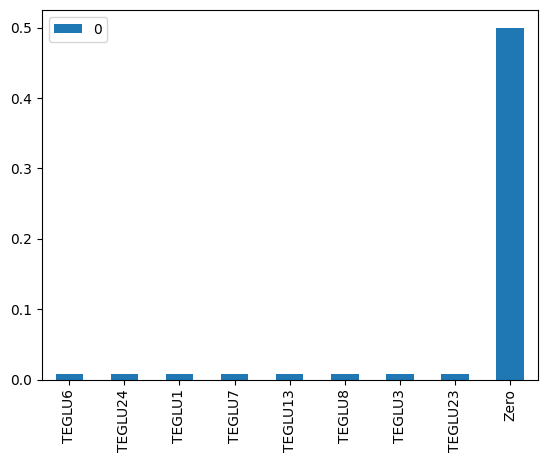

In [20]:
np.exp(log_prior).plot.bar()

Combining now the negative binomial loglikelihood and the prior we have: 

In [21]:
teglu_total_df = teglu_contr_df.sum(axis=0) + log_prior.squeeze()
teglu_total_df

TEGLU6    -104.568492
TEGLU24   -104.875006
TEGLU1    -105.134643
TEGLU7    -105.874769
TEGLU13   -106.528935
TEGLU8    -106.765636
TEGLU3    -107.207379
TEGLU23   -107.262512
Zero      -104.401909
dtype: float64

Hence Zero class now has the highest loglikelihood but it is really close (almost the same) to the second best: TEGLU6

In [22]:
# Lets now compare the Zero class to TEGLU6 (second best)
my_df = teglu_contr_df[['TEGLU6', 'Zero']]

In [23]:
# calc the difference between the contributions
diff = teglu_contr_df['TEGLU6'] - teglu_contr_df['Zero']
my_df = my_df.assign(diff = diff)

In [24]:
# Top 5 genes that are cotributing most for the TEGLU6 cell type
my_df.sort_values(by='diff', ascending=False).head(5)

,TEGLU6,Zero,diff
Rgs4,-5.815919,-9.231148,3.415229
Cd81,-4.843744,-6.186625,1.342881
Enc1,-4.856100,-6.186625,1.330525
Prkca,-5.019649,-6.186625,1.166976
Nrn1,-1.995080,-3.142103,1.147023


In [25]:
# Top 5 genes that are cotributing most for the Zero cell type
my_df.sort_values(by='diff', ascending=False).tail(5)

,TEGLU6,Zero,diff
Cplx2,-0.422331,-0.09758,-0.324751
Cxcl14,-0.454831,-0.09758,-0.357250
Tshz2,-0.879744,-0.09758,-0.782163
Nrgn,-1.055543,-0.09758,-0.957963
Cck,-1.356475,-0.09758,-1.258894


It is worth noting that in the next iteration, Zero class falls from its top position and the most likely class is TEGLU6